In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps, quad

### about this file

orbits are calculated by solving $d^2 r/ dt^2  - L^2 / r^3 = - \nabla \phi(r,t)$

in order to efficiently calcualte sampled neutrino orbits, we need a table of potentials $\phi(r, t$) at each radius and time.  The potential evolves dynamically as the local dark matter halo evolves, so it is much more efficient to calculate potentials first then write a lookup fn.  

The output is a file with the gradient of the potential at each r and z (z is analogous to t in this instance).

In [4]:
m_and_c_output = pd.read_table('mandcoutput.txt', skiprows=1, header=None, delimiter='  ')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [5]:
m_and_c = m_and_c_output[[0, 1, 2, 16]].rename(columns={0: 'z', 1: 'halo_mass', 2: 'c', 16: 'universe_age'})
m_and_c.head()

,z,halo_mass,c,universe_age
0,0.400000,1.000000e+15,4.107080,6.685994e+09
1,0.432610,9.358697e+14,4.101386,6.501938e+09
2,0.465980,8.745112e+14,4.096010,6.321164e+09
3,0.500127,8.158471e+14,4.090998,6.143718e+09
4,0.535069,7.599395e+14,4.086326,5.969643e+09


In [6]:
camb = pd.read_table('camb_matterpower2.txt', delimiter='   ', header=None)
camb.columns = ['cambK', 'cambP']
camb.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,cambK,cambP
0,0.000100,569.47
1,0.000102,580.50
2,0.000104,591.75
3,0.000106,603.21
4,0.000108,614.90


In [46]:
from scipy.special import spherical_jn

# constants and function definitions
omegaM = 0.27;
omegaLambda = 1. - omegaM;
H0 = 71.554798 # [kpc / Gyr]
G = 4.519e-9; # [Mpc * (km/s)^2 / M_sun]

def get_z(idx_z):
    return m_and_c.iloc[idx_z].z

def Hubble(idx_z):
    return np.sqrt(H0 ** 2 * (omegaM * (1 + get_z(idx_z)) ** 3 + omegaLambda))

def cOverTime(idx_z):
    return m_and_c.iloc[idx_z].c

def MassOverTime(idx_z):
    return m_and_c.iloc[idx_z].halo_mass
    
def omega(idx_z):
    return (omegaM * (1 + get_z(idx_z)) ** 3) / (omegaM * (1 + get_z(idx_z)) ** 3 + omegaLambda)
    
def x(idx_z):
    return omega(idx_z) - 1
    
def DeltaC(idx_z):
    return 18 * np.pi ** 2 + 82 * x(idx_z) - 39 * x(idx_z) ** 2

def rhoC(idx_z):
    return (3 * H0 ** 2 / (8 * np.pi * G)) * (omegaM * (1 + get_z(idx_z)) ** 3 + omegaLambda)
    
def rv(idx_z):
    return ((3 * MassOverTime(idx_z)) / (4 * np.pi * rhoC(idx_z) * DeltaC(idx_z))) ** (1. / 3)
    
def rs(idx_z):
    return rv(idx_z) / cOverTime(idx_z)
    
def MassIntegrand(r, idx_z):
    return r ** 2 / (((r * cOverTime(idx_z)) / rv(idx_z)) * (1 + (r * cOverTime(idx_z))/rv(idx_z)) ** 2)

def rhoSOverTime(idx_z):
    n = 100  # number of points in integration
    r_list = np.linspace(0.00001, rv(idx_z), num=n)
    return MassOverTime(idx_z) / (4 * np.pi * simps(MassIntegrand(r_list, idx_z), r_list))

def rhoNFW(R, idx_z):
    if R == 0: 
        return 0.0;
    else:
        return rhoSOverTime(idx_z) / ((R / rs(idx_z)) * (1 + R / rs(idx_z)) ** 2)

# below, idx corresponds to k
def get_k(idx_k):
    return camb.iloc[idx_k]['cambK']
    
def PowerSpectrum(idx_k):
#     y = interp1d(cambK, cambP)
#     yExtrapolated = interp1d(kExtrapolated, yFitWithZero)
#     if k >= min(cambK):
#         return y(k)
#     else:
#         return yExtrapolated(k)
    return camb.iloc[idx_k]['cambP']

def SigmaMIntegrand(idx_k, r):
    return PowerSpectrum(idx_k) * (spherical_jn(1, (get_k(idx_k) * r)) / r) ** 2

def SigmaM(r):
    k_list = range(camb['cambK'].shape[0])
    return 3 / (np.pi * np.sqrt(2)) * np.sqrt(simps(SigmaMIntegrand(k_list, r), k_list))

def GammaIntegrand(idx_k, r1, r2):
    return (spherical_jn(1, (get_k(idx_k) * r1)) / r1) * (spherical_jn(1, (get_k(idx_k) * r2)) / r2) * PowerSpectrum(idx_k)

def Gamma(r1, r2):
    k_list = range(camb['cambK'].shape[0])
    return 9 * simps(GammaIntegrand(k_list, r1, r2), k_list) / (2 * np.pi ** 2 * SigmaM(r1) * SigmaM(r2))

def ProfileMass(R, idx_z):
    # returns enclosed mass in NFW profile--formula straight from wikipedia
    return 4 * np.pi * rhoSOverTime(idx_z) * (rs(idx_z) ** 3) * (np.log((R + rs(idx_z))/rs(idx_z)) - R / (R + rs(idx_z)))


def dPhi_dr(R, idx_z):
    # calculates time-dependent newtonian gravitational potential at (r, z)
    H = H0 * np.sqrt(omegaM * (1 + get_z(idx_z)) ** 3 + omegaLambda) # [kpc / Gyr]
#     return 4.49e-6 / (R ** 2 * H * (1 + get_z(idx_z))) * ProfileMass(R, idx_z)
    return 4.3e-6 / (R ** 2 * H * (1 + get_z(idx_z))) * ProfileMass(R, idx_z)

def dPhi_dr(R, idx_z):
    r_v = rv(idx_z)
    r_s = rs(idx_z)
    M_vir = 4 / 3 * np.pi * rhoC(idx_z) * DeltaC(idx_z) * r_v ** 3
    G = 4.3e-6
    
    c = r_v / r_s
    return -1.0 * G * M_vir * (R / (R + r_s) - np.log(1 + R / r_s)) / ((np.log(1 + c) - c / (1 + c)) * R ** 3)
    

### NFW potential profile

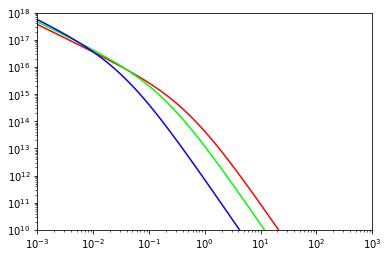

In [8]:
plt.loglog(np.logspace(-3, 3, 100), [rhoNFW(i, 0) for i in np.logspace(-3, 3, 100)], color='r', label='z=0.4')
plt.loglog(np.logspace(-3, 3, 100), [rhoNFW(i, 22) for i in np.logspace(-3, 3, 100)], color='lime', label='z=1.3')
plt.loglog(np.logspace(-3, 3, 100), [rhoNFW(i, 51) for i in np.logspace(-3, 3, 100)], color='b', label='z=3.5')
plt.ylim(10**10, 10**18)
plt.xlim(10 ** (-3), 10 ** (3))
plt.show()

In [47]:
r_values = np.logspace(0, 4, 1001, endpoint=1)
z_values = m_and_c.loc[m_and_c.z < 10].z.index

potential_grid = pd.DataFrame(index=r_values, columns=z_values).apply(lambda x: dPhi_dr(x.index, x.name))
potential_grid.columns = m_and_c.loc[m_and_c.z < 10].z
with open('potential_grid.plk', 'wb') as f:
    pickle.dump(potential_grid, f)

In [40]:
import pickle

In [41]:
import seaborn as sns

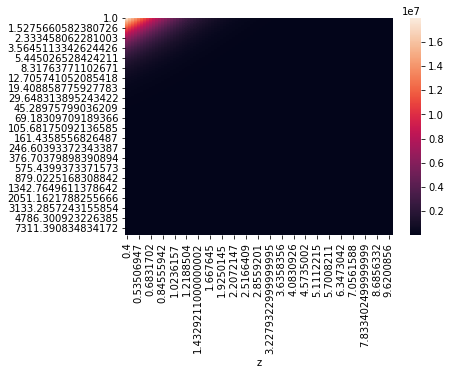

In [45]:
sns.heatmap(potential_grid)
plt.show()

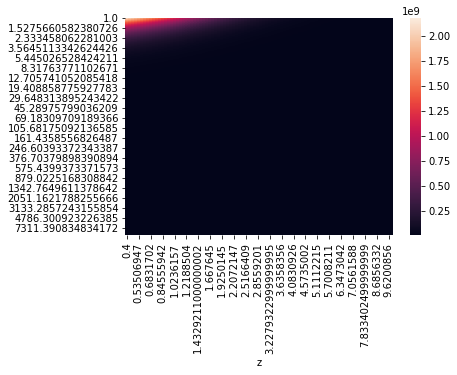

In [48]:
sns.heatmap(potential_grid)
plt.show()

In [49]:
from scipy.interpolate import NearestNDInterpolator

In [50]:
coords = np.vstack(map(np.ravel, np.meshgrid(r_values, z_values))).T
values = np.ravel(potential_grid.T.values)

potential_interpolator = NearestNDInterpolator(coords, values)

def get_potential(R, z):
    return potential_interpolator.__call__(R, z)

In [51]:
%timeit potential_interpolator.__call__(50, 50)

88.9 µs ± 4.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [52]:
%timeit get_potential(50., 50.)

90.1 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
